# import、install

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.7 MB/s et

In [3]:
from typing import Dict, Tuple, List, Any, Iterable
from __future__ import annotations
from abc import ABC, abstractmethod

import pandas as pd
import gradio as gr

import sys
sys.path.append('/content/drive/MyDrive/local_cuisine_search_app/modules')

from my_gradio import GrBlocks, GrLayout, GrComponent, GrListener
from pandas_utility import save_csv_df, update_row

# クラスの定義

In [4]:
class App(GrBlocks):
    """
    文頭表現分類アプリのクラス
    """
    @staticmethod
    def _create_children_and_listeners(
            read_path: str, save_dir: str, file_name: str
    ) -> Tuple[Dict[str, Any] | List[Any], List[Any]]:
        """
        アプリの子要素と、イベントリスナーの作成

        Parameters
        ----------
        read_path : str
            分類対象である文頭表現のデータフレームのパス
        save_dir : str
            データフレームの保存先ディレクトリ
        file_name : str
            保存するファイル名

        Returns
        -------
        Tuple[Dict[str, Any] | List[Any], List[Any]]
            アプリの子要素とイベントリスナー
        """
        label_dic: Dict[str, Tuple[str] | Tuple[str, str, str]] = {
            'unclassified': ('未分類な文頭表現',),
            'almighty': ('全ての文末表現に繋がる文頭表現',),
            'major': (
                '多数派の表現にのみ繋がる文頭表現',
                '多数派の表現',
                'を教えてください'
            ),
            'minor': (
                '少数派の表現にのみ繋がる文頭表現',
                '少数派の表現',
                'はありますか？'
            ),
            'remove': ('削除する文頭表現',)
        }

        unclassified_label = list(label_dic.keys())[0]

        original_df = OriginalDataframe(
            read_path, save_dir, file_name, unclassified_label
        )
        specific_df = SpecificDataframe(
            unclassified_label, original_df.df
        )

        row_info = RowInfoTextbox(specific_df)
        expr_texts = App._create_expr_texts(label_dic, row_info)
        classify_btns = App._create_classify_btns(label_dic)
        save_df_btn = SaveDataframeButton()
        class_dfs = ClassDataframes(label_dic, specific_df)

        children = [row_info, expr_texts, classify_btns, save_df_btn, class_dfs]

        row_info_change = GrListener(
            trigger=row_info.comp.change,
            fn=lambda expr_texts=expr_texts: row_info.changed(expr_texts),
            outputs=expr_texts,
            scroll_to_output=True
        )
        classify_btn_click = App._create_classify_btns_click_listeners(
            original_df, specific_df, classify_btns, row_info, class_dfs
        )
        save_btn_click = GrListener(
            trigger=save_df_btn.comp.click,
            fn=original_df.save
        )
        dfs_select = App._create_dfs_select_listener(
            class_dfs, specific_df, row_info
        )

        listeners = [
            row_info_change, classify_btn_click, save_btn_click, dfs_select
        ]

        return children, listeners

    @staticmethod
    def _create_expr_texts(
            label_dic: Dict[str, Tuple[str] | Tuple[str, str, str]],
            row_info: RowInfoTextbox
    ) -> ExpressionTextboxs:
        """
        expr_textsの作成

        Parameters
        ----------
        label_dic : Dict[str, Tuple[str]  |  Tuple[str, str, str]]
            各クラスのラベルとその情報の辞書
        row_info : RowInfoTextbox
            現在分類対象の行の情報を持つコンポーネントのオブジェクト

        Returns
        -------
        ExpressionTextboxs
            現在分類対象の文頭表現の具体的な表現例を表示する
            レイアウトのオブジェクト
        """
        comps_labels_and_exprs: List[List[str]] = []
        for cls_label, label_info in list(label_dic.items())[2:-1]:
            comp_label = label_info[1]
            comp_label = f'{cls_label}: {comp_label}'
            expr = label_info[2]

            comp_label_and_expr = [comp_label, expr]

            comps_labels_and_exprs.append(comp_label_and_expr)

        classifying_row_value = row_info.values[1]

        expr_texts = ExpressionTextboxs(
            comps_labels_and_exprs, classifying_row_value
        )

        return expr_texts

    @staticmethod
    def _create_classify_btns(
            label_dic: Dict[str, Tuple[str] | Tuple[str, str, str]]
    ) -> ClassifyButtons:
        """
        classify_btnsの作成

        Parameters
        ----------
        label_dic : Dict[str, Tuple[str]  |  Tuple[str, str, str]]
            各クラスのラベルとその情報の辞書

        Returns
        -------
        ClassifyButtons
            分類ボタンのレイアウトのオブジェクト
        """
        comps_labels = [label for label in list(label_dic.keys())[1:]]
        classify_btns = ClassifyButtons(comps_labels)

        return classify_btns

    @staticmethod
    def _create_classify_btns_click_listeners(
            original_df: OriginalDataframe,
            specific_df: SpecificDataframe,
            classify_btns: ClassifyButtons,
            row_info: RowInfoTextbox,
            class_dfs: ClassDataframes
    ) -> List[GrListener]:
        """
        分類ボタンクリックイベントリスナーの作成

        Parameters
        ----------
        original_df : OriginalDataframe
            特殊トークンを具体的な語彙に置き換えていない
            文頭表現のデータフレームのオブジェクト
        specific_df : SpecificDataframe
            特殊トークンを具体的な語彙に置き換えた
            文頭表現のデータフレームのオブジェクト
        classify_btns : ClassifyButtons
            分類ボタンのレイアウトのオブジェクト
        row_info : RowInfoTextbox
            現在分類対象の行の情報を持つコンポーネントのオブジェクト
        class_dfs : ClassDataframes
            同じクラスに分類されている行だけをまとめた
            データフレーム達のレイアウトのオブジェクト

        Returns
        -------
        List[GrListener]
            分類ボタンクリックイベントリスナーのオブジェクトのリスト
        """
        update_row_info = GrListener(
            fn=lambda specific_df=specific_df: row_info.update(specific_df),
            outputs=row_info
        )
        listeners = []  # ※１
        for btn in classify_btns.children:
            def clicked(
                    btn_label: str,
                    row_info: RowInfoTextbox = row_info,  # ※２
                    original_df: OriginalDataframe = original_df,
                    specific_df: SpecificDataframe = specific_df,
                    class_dfs: Dict[str, ClassDataframe] = class_dfs.children
            ) -> Dict[gr.Dataframe, pd.DataFrame]:
                row_info = row_info.values

                return ClassifyButton.clicked(
                    btn_label, row_info, original_df, specific_df, class_dfs
                )

            classify_btn_click = GrListener(
                trigger=btn.comp.click,
                fn=clicked,
                inputs=btn,
                outputs=class_dfs,
                thens=update_row_info
            )

            listeners.append(classify_btn_click)

        return listeners

    @staticmethod
    def _create_dfs_select_listener(
            class_dfs: ClassDataframes,
            specific_df: SpecificDataframe,
            row_info: RowInfoTextbox
    ) -> GrListener:
        """
        データフレームセレクトイベントリスナーの作成

        Parameters
        ----------
        class_dfs : ClassDataframes
            同じクラスに分類されている行だけをまとめた
            データフレーム達のレイアウトのオブジェクト
        specific_df : SpecificDataframe
            特殊トークンを具体的な語彙に置き換えた
            文頭表現のデータフレームのオブジェクト
        row_info : RowInfoTextbox
            現在分類対象の行の情報を持つコンポーネントのオブジェクト

        Returns
        -------
        GrListener
            データフレームセレクトイベントリスナーのオブジェクト
        """
        def selected(
                selected_row: gr.SelectData,
                specific_df: SpecificDataframe = specific_df
        ) -> List[int | str] | gr.Textbox:
            row_value = selected_row.value

            return row_info.update(specific_df, row_value)

        dfs_select = GrListener(
            trigger=[df.comp.select for df in class_dfs.children.values()],
            fn=selected,
            outputs=row_info
        )

        return dfs_select


class ClassifyingDataframe(ABC):
    """
    分類対象のデータフレーム用の抽象クラス
    Attributes
    ----------
    _class_col: str
        分類クラス列の列名
    """
    _class_col = 'class'

    def __init__(self, *args: Any):
        """
        コンストラクタ

        データフレームの初期化
        """
        self.df = self._create(*args)

    @classmethod
    @abstractmethod
    def _create(cls, *args: Any) -> pd.DataFrame:
        """
        データフレームの初期化

        Returns
        -------
        pd.DataFrame
            初期化されたデータフレーム
        """
        pass

    def update(self, row_idx: int, value: Any) -> None:
        """
        行の更新

        Parameters
        ----------
        row_idx : int
            更新対象の行インデックス
        value : Any
            新しいクラスのラベル
        """
        self.df.at[row_idx, self._class_col] = value


class OriginalDataframe(ClassifyingDataframe):
    """
    特殊トークンを具体的な語彙に置き換えていない文頭表現のデータフレームのクラス

    Attributes
    ----------
    _save_dir : str
        分類したデータフレームの保存先ディレクトリ
    _file_name : str
        保存する分類したデータフレームのファイル名
    """
    def __init__(
            self, read_path: str, save_dir: str, file_name: str,
            unclassified_label: str
    ):
        """
        コンストラクタ

        Parameters
        ----------
        read_path : str
            分類対象であるデータフレームが保存されているパス
        save_dir : str
            分類したデータフレームの保存先ディレクトリ
        file_name : str
            保存する分類したデータフレームのファイル名
        unclassified_label : str
            未分類のクラスのラベル
        """
        self._save_dir = save_dir
        self._file_name = file_name

        super().__init__(read_path, unclassified_label)

    @classmethod
    def _create(cls, read_path: str, unclassified_label: str) -> pd.DataFrame:
        """
        データフレームの作成

        Parameters
        ----------
        read_path : str
            データフレームが保存されているパス
        unclassified_label : str
            未分類クラスのラベル

        Returns
        -------
        pd.DataFrame
            特殊トークンを具体的な語彙に置き換えていない文頭表現のデータフレーム

        Raises
        ------
        ValueError
            読み込んだデータフレームに、同じ値の行が複数あった場合
        """
        df = pd.read_csv(read_path)

        is_duplicated = df[df.columns[0]].duplicated()
        if any(is_duplicated):
            raise ValueError('値が重複している行があります')

        if cls._class_col not in df.columns:
            df.columns = ['文頭表現']

            class_col_values = [unclassified_label for _ in range(len(df))]
            df[cls._class_col] = class_col_values

        return df

    def save(self) -> None:
        """
        データフレームの保存
        """
        save_csv_df(self.df, self._file_name, self._save_dir)
        gr.Info('保存しました')


class SpecificDataframe(ClassifyingDataframe):
    """
    特殊トークンを具体的な語彙に置き換えた文頭表現のデータフレームのクラス

    Attributes
    ----------
    _unclassified_label : str
        未分類のクラスのラベル
    _expr_and_class_cols : Index[str]
        文頭表現の列と、クラスの列の列名のイテラブルオブジェクト
    _sentence_col : str
        文頭表現の列の列名
    """
    _no_rows = '該当なし'
    _no_unclassified_rows_message = '未分類の行はありません'

    def __init__(self, unclassified_label: str, original_df: pd.DataFrame):
        """
        コンストラクタ

        インスタンス変数の初期化

        Parameters
        ----------
        unclassified_label : str
            未分類のクラスのラベル
        original_df : pd.DataFrame
            特殊トークンを具体的な語彙に置き換えていない文頭表現のデータフレーム
        """
        self._unclassified_label = unclassified_label
        self._expr_and_class_cols = original_df.columns
        self._sentence_col = self._expr_and_class_cols[0]

        super().__init__(original_df)

    def _create(self, original_df: pd.DataFrame) -> pd.DataFrame:
        """
        特殊トークンを具体的な語彙に置き換えた文頭表現のデータフレームの作成

        Parameters
        ----------
        original_df : pd.DataFrame
            特殊トークンを具体的な語彙に置き換えていない文頭表現のデータフレーム

        Returns
        -------
        pd.DataFrame
            特殊トークンを具体的な語彙に置き換えた文頭表現のデータフレーム
        """
        df = original_df.copy()

        words_dict = {
            '[AREA]': '愛知県',
            '[TYPE]': '肉料理',
            '[SZN]': '春',
            '[INGR]': 'リンゴ',
            '[PRON]': '料理'
        }
        all_tokens = words_dict.keys()

        df[self._sentence_col] = df[self._sentence_col].apply(
            lambda row: SpecificDataframe._replace_token(
                row, words_dict, all_tokens
            )
        )

        return df

    @staticmethod
    def _replace_token(
            row: str, words_dict: Dict[str, str], all_tokens: Iterable[str]
    ) -> str:
        """
        文頭表現の特殊トークンを具体的な語彙へ置き換え

        Parameters
        ----------
        row : str
            特殊トークンを含む文頭表現
        words_dict : Dict[str, str]
            特殊トークンに対する具体的な語彙を持つ辞書
        all_tokens : Iterable[str]
            文頭表現に含まれる可能性がある全ての特殊トークンのリスト

        Returns
        -------
        str
            特殊トークンが具体的な語彙に置き換えられた文頭表現
        """
        row_tokens = [token for token in all_tokens if token in row]

        for token in row_tokens:
            replace_word = words_dict[token]
            row = row.replace(token, replace_word)

        return row

    def find_same_label_rows(self, label: str) -> pd.DataFrame:
        """
        同一のクラスの文頭表現のデータフレームの作成

        Parameters
        ----------
        label : str
            データフレームにまとめるクラスのラベル

        Returns
        -------
        pd.DataFrame
            同一のクラスの文頭表現のデータフレーム
        """
        is_same_label = self.df[self._class_col] == label
        rows = self.df.loc[is_same_label, [self._sentence_col]]

        if rows.empty:
            rows = pd.DataFrame({self._sentence_col: [self._no_rows]})

        return rows

    def find_row_by_value(
            self, row_value: str
    ) -> List[int | str] | None:
        """
        row_valueを値に持つ行の情報の取得

        Parameters
        ----------
        row_value : str
            行の値である文頭表現

        Returns
        -------
        List[int | str] | None
            行の情報のリスト
        """
        if row_value == self._no_rows:
            return None

        is_valid_row = self.df[self._sentence_col] == row_value
        row: pd.DataFrame = self.df.loc[is_valid_row, self._expr_and_class_cols]

        row_idx: int = row.index.tolist()[0]

        row_info = SpecificDataframe._create_row_info(row_idx, row)

        return row_info

    @staticmethod
    def _create_row_info(
            row_idx: int, row: pd.Series | pd.DataFrame
    ) -> List[int | str]:
        """
        行の情報のリストの作成

        Parameters
        ----------
        row_idx : int
            行のインデックス
        row : pd.Series | pd.DataFrame
            row_info作成対象行のシリーズか、データフレーム

        Returns
        -------
        List[int | str]
            行の情報のリスト
            行インデックス、文頭表現、クラスの情報を持つ
        """
        if isinstance(row, pd.Series):
            row_value_and_label: List[str] = row.values.tolist()

        else:
            row_value_and_label: List[str] = row.values.tolist()[0]

        row_info = [row_idx] + row_value_and_label

        return row_info

    def find_first_unclassified_row(self) -> List[int | str]:
        """
        最初の未分類の行の取得

        データフレーム上で一番行インデックスが小さい、未分類の行を取得する

        Returns
        -------
        List[int | str]
            行の情報のリスト
            行インデックス、文頭表現、クラスの情報を持つ
        """
        unclassified_rows = self.df[self._class_col] == self._unclassified_label
        row_idx = self.df[unclassified_rows].first_valid_index()

        if row_idx is None:
            gr.Info(self._no_unclassified_rows_message)
            row_idx = 0

        row_info = self.find_row_by_idx(row_idx)

        return row_info

    def find_row_by_idx(self, row_idx: int) -> List[int | str]:
        """
        行インデックスから行の情報の取得

        Parameters
        ----------
        row_idx : int
            行インデックス

        Returns
        -------
        List[int | str]
            行の情報のリスト
            行インデックス、文頭表現、クラスの情報を持つ
        """
        row: pd.Series  = self.df.loc[row_idx, self._expr_and_class_cols]
        row_info = self._create_row_info(row_idx, row)

        return row_info

    def classify_btn_clicked(
            self, row_idx: int, new_label: str, fmr_label: str
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        分類ボタンがクリックされたときの処理

        self.dfを更新し、アプリ上のデータフレーム更新用の
        二つのデータフレームを返す

        Parameters
        ----------
        row_idx : int
            更新対象の行インデックス
        new_label : str
            更新対象行の新しいクラスのラベル
        fmr_label : str
            更新対象行の元のクラスのラベル

        Returns
        -------
        Tuple[pd.DataFrame, pd.DataFrame]
            元のクラスのデータフレームと、新しいクラスのデータフレーム
        """
        self.update(row_idx, new_label)

        fmr_label_rows = self.find_same_label_rows(fmr_label)
        new_label_rows = self.find_same_label_rows(new_label)

        return fmr_label_rows, new_label_rows


class RowInfoTextbox(GrComponent):
    """
    分類対象行の情報のリストを持つテキストボックスのクラス

    Attributes
    ----------
    values : List[int | str]
        行の情報のリスト
        行インデックス、文頭表現、クラスの情報を持つ
    """
    def __init__(self, specific_df: SpecificDataframe):
        """
        コンストラクタ

        分類対象の行の情報の取得

        Parameters
        ----------
        specific_df : SpecificDataframe
            特殊トークンを具体的な語彙に置き換えた
            文頭表現のデータフレームのオブジェクト
        """
        self.update(specific_df)

        super().__init__()

    def _create(self) -> gr.Textbox:
        """
        コンポーネントの作成

        Returns
        -------
        gr.Textbox
            行の情報のリストを値に持つテキストボックス
        """
        comp = gr.Textbox(value=self.values, show_label=False, visible=False)

        return comp

    def update(
            self, specific_df: SpecificDataframe, row_value: str | None = None
    ) -> List[int | str] | gr.Textbox:
        """
        次の分類対象の行の情報の取得

        Parameters
        ----------
        specific_df : SpecificDataframe
            特殊トークンを具体的な語彙に置き換えた
            文頭表現のデータフレームのオブジェクト
        row_value : str | None, optional
            次の分類対象の行の文頭表現, by default None

        Returns
        -------
        List[int | str] | gr.Textbox
            行の情報のリスト
            行インデックス、文頭表現、クラスの情報を持つ
        """
        if row_value:
            row_info = specific_df.find_row_by_value(row_value)

        else:
            row_info = specific_df.find_first_unclassified_row()

        if row_info is None:
            return gr.Textbox()

        self.values = row_info  # ※３

        return row_info

    def changed(self, expr_texts: ExpressionTextboxs) -> List[str]:
        """
        changeイベントリスナーのメソッド

        expr_textsのupdateメソッドに、次の分類対象の行の文頭表現を渡す

        Parameters
        ----------
        expr_texts : ExpressionTextboxs
            文頭表現に具体的な文末表現を付与した
            テキストボックスのレイアウトのオブジェクト

        Returns
        -------
        List[str]
            文頭表現に具体的な文末表現を付与した文字列のリスト
        """
        row_value = self.values[1]
        textbox_values = expr_texts.update(row_value)

        return textbox_values


class ExpressionTextboxs(GrLayout):
    """
    文頭表現に具体的な文末表現を付与したテキストボックスのレイアウトのクラス

    全ての特異なクラスに該当する文末表現を、
    文頭表現に付与したテキストボックスを持つ

    Attributes
    ----------
    layout_type : gr.Column
        GradioのColumn
    """
    layout_type = gr.Column

    def __init__(self, labels_and_exprs: List[Tuple[str, str]], row_value: str):
        """
        コンストラクタ

        Parameters
        ----------
        labels_and_exprs : List[Tuple[str, str]]
            各テキストボックスのラベルとそれぞれの文末表現のタプルを持つリスト
        row_value : str
            文頭表現の文字列
        """
        super().__init__(labels_and_exprs, row_value)

    def _create(
            self, labels_and_exprs: List[Tuple[str, str]], row_value: str
    ) -> List[ExpressionTextbox]:
        """
        子要素の作成

        Parameters
        ----------
        labels_and_exprs : List[Tuple[str, str]]
            各テキストボックスのラベルとそれぞれの文末表現のタプルを持つリスト
        row_value : str
            文頭表現の文字列

        Returns
        -------
        List[ExpressionTextbox]
            各特異なクラスの文末表現を付与された表現の
            テキストボックスのオブジェクトのリスト
        """
        children = [
            ExpressionTextbox(label_and_expr, row_value)
            for label_and_expr in labels_and_exprs
        ]

        return children

    def update(self, row_value: str) -> List[str]:
        """
        全表現のテキストボックスの更新

        全ての表現のテキストボックスの文頭表現を分類対象の行のものに変更する

        Parameters
        ----------
        row_value : str
            次の分類対象の行の文頭表現

        Returns
        -------
        List[str]
            次の分類対象の行の文頭表現に
            それぞれの文末表現が付与された文字列のリスト
        """
        textbox_values = [textbox.update(row_value) for textbox in self.children]

        return textbox_values


class ExpressionTextbox(GrComponent):
    """
    特異なクラスに該当する文末表現を、
    文頭表現に付与したテキストボックスのオブジェクト
    """
    def __init__(self, label_and_expr: Tuple[str, str], row_value: str):
        """
        コンストラクタ

        インスタンス変数の作成

        Parameters
        ----------
        label_and_expr : Tuple[str, str]
            テキストボックスのラベルと文末表現のタプルを持つリスト
        row_value : str
            文頭表現
        """
        self._end_of_sentence = label_and_expr[1]
        comp_label = label_and_expr[0]

        super().__init__(comp_label, row_value)

    def _create(self, comp_label: str, row_value: str) -> gr.Textbox:
        """
        コンポーネントの作成

        Parameters
        ----------
        comp_label : str
            コンポーネントのラベル
        row_value : str
            文頭表現

        Returns
        -------
        gr.Textbox
            文頭表現に文末表現を付与した文字列を持つテキストボックス
        """
        value = self.update(row_value)
        comp = gr.Textbox(value=value, label=comp_label)

        return comp

    def update(self, row_value: str) -> str:
        """
        コンポーネントの更新

        文頭表現を次の分類対象の行の文頭表現に変更する

        Parameters
        ----------
        row_value : str
            次の分類対象の行の文頭表現

        Returns
        -------
        str
            次の分類対象の行の文頭表現に、文末表現を付与した文字列
        """
        comp_value = row_value + self._end_of_sentence

        return comp_value


class ClassifyButtons(GrLayout):
    """
    分類ボタンのレイアウトのクラス

    Attributes
    ----------
    layout_type : gr.Row
        GradioのRow
    """
    layout_type = gr.Row

    def __init__(self, comps_labels: List[str]):
        """
        コンストラクタ

        Parameters
        ----------
        comps_labels : List[str]
            各ボタンのバリュー
        """
        super().__init__(comps_labels)

    def _create(self, comps_labels: List[str]) -> List[ClassifyButton]:
        """
        子要素の作成

        Parameters
        ----------
        comps_labels : List[str]
            各ボタンのバリュー

        Returns
        -------
        List[ClassifyButton]
            分類ボタンのオブジェクトのリスト
        """
        children = [ClassifyButton(comp_label) for comp_label in comps_labels]

        return children


class ClassifyButton(GrComponent):
    """
    分類ボタンのクラス
    """
    def __init__(self, label: str):
        """
        コンストラクタ

        Parameters
        ----------
        label : str
            クラスのラベル
        """
        super().__init__(label)

    def _create(self, label: str) -> gr.Button:
        """
        コンポーネントの作成

        Parameters
        ----------
        label : str
            クラスのラベル

        Returns
        -------
        gr.Button
            分類ボタンのコンポーネント
        """
        comp = gr.Button(value=label)

        return comp

    @staticmethod
    def clicked(
            btn_label: str,
            row_info: List[int | str],
            original_df: OriginalDataframe,
            specific_df: SpecificDataframe,
            class_dfs: Dict[str, ClassDataframe]
    ) -> Dict[gr.Dataframe, pd.DataFrame]:
        """
        分類ボタンクリックイベントリスナーの関数

        original_dfとspecific_dfの更新と、
        アプリ上の更新が必要なデータフレームを更新する

        Parameters
        ----------
        btn_label : str
            クリックしたボタンのvalue
        row_info : List[int  |  str]
            分類した行の情報のリスト
            行インデックス、文頭表現、クラスの情報を持つ
        original_df : OriginalDataframe
            特殊トークンを具体的な語彙に置き換えていない
            文頭表現のデータフレームのオブジェクト
        specific_df : SpecificDataframe
            特殊トークンを具体的な語彙に置き換えた
            文頭表現のデータフレームのオブジェクト
        class_dfs : Dict[str, ClassDataframe]
            各クラスに対するアプリ上のデータフレームの辞書

        Returns
        -------
        Dict[gr.Dataframe, pd.DataFrame]
            アプリ上の、更新対象のデータフレームとそのvalue
        """
        fmr_label: str = row_info[-1]

        fmr_label_df = class_dfs[fmr_label]

        if btn_label == fmr_label:
            return {fmr_label_df.comp: gr.DataFrame()}

        row_idx = row_info[0]

        original_df.update(row_idx, btn_label)

        fmr_label_rows, new_label_rows = specific_df.classify_btn_clicked(
            row_idx, btn_label, fmr_label
        )

        new_label_df = class_dfs[btn_label]

        updating_dfs = {
            fmr_label_df.comp: fmr_label_rows,
            new_label_df.comp: new_label_rows
        }

        return updating_dfs


class SaveDataframeButton(GrComponent):
    """
    保存ボタンのクラス
    """
    def _create(self) -> gr.Button:
        """
        コンポーネントの作成

        Returns
        -------
        gr.Button
            保存ボタンのコンポーネント
        """
        comp = gr.Button(value='保存')

        return comp


class ClassDataframes(GrLayout):
    """
    全クラスのデータフレームのレイアウトのクラス

    Attributes
    ----------
    layout_type : gr.Column
        GradioのColumn
    """
    layout_type = gr.Column

    def __init__(
            self,
            label_dic: Dict[str, Tuple[str] | Tuple[str, str, str]],
            specific_df: SpecificDataframe
    ):
        """
        コンストラクタ

        Parameters
        ----------
        label_dic : Dict[str, Tuple[str]  |  Tuple[str, str, str]]
            クラスのラベルに対する情報のタプルを持つ辞書
        specific_df : SpecificDataframe
            特殊トークンを具体的な語彙に置き換えた文頭表現のデータフレームのオブジェクト
        """
        super().__init__(label_dic, specific_df)

    def _create(
            self,
            label_dic: Dict[str, Tuple[str] | Tuple[str, str, str]],
            specific_df: SpecificDataframe
    ) -> Dict[str, ClassDataframe]:
        """
        子要素の作成

        Parameters
        ----------
        label_dic : Dict[str, Tuple[str]  |  Tuple[str, str, str]]
            クラスのラベルに対する情報のタプルを持つ辞書
        specific_df : SpecificDataframe
            特殊トークンを具体的な語彙に置き換えた
            文頭表現のデータフレームのオブジェクト

        Returns
        -------
        Dict[str, ClassDataframe]
            クラスのラベルに対するアプリ上のデータフレームの辞書
        """
        children = {}
        for label, label_info in label_dic.items():
            rows = specific_df.find_same_label_rows(label)
            comp_label = label_info[0]
            class_df = ClassDataframe(label, comp_label, rows)

            children[label] = class_df

        return children


class ClassDataframe(GrComponent):
    """
    データフレームのオブジェクトのクラス

    特定のクラスの行だけのアプリ上のデータフレームのオブジェクトを持つ
    """
    def __init__(self, label: str, comp_label: str, rows: pd.DataFrame):
        """
        コンストラクタ

        Parameters
        ----------
        label : str
            クラスのラベル
        comp_label : str
            コンポーネントのラベルの一部
        rows : pd.DataFrame
            該当行のデータフレーム
        """
        super().__init__(label, comp_label, rows)

    def _create(
            self, label: str, comp_label: str, rows: pd.DataFrame
    ) -> gr.Dataframe:
        """
        コンポーネントの作成

        Parameters
        ----------
        label : str
            クラスのラベル
        comp_label : str
            コンポーネントのラベルの一部
        rows : pd.DataFrame
            該当行のデータフレーム

        Returns
        -------
        gr.Dataframe
            特定のクラスの行だけのデータフレームを持つコンポーネント
        """
        comp_label = f'{label}: {comp_label}'
        comp = gr.Dataframe(value=rows, label=comp_label)

        return comp

# 実行

In [7]:
# read_pathに分類途中のデータフレームのパスを指定すると、途中から分類を再開できる
read_path = '/content/drive/MyDrive/local_cuisine_search_app/data/processed_data/04_encoded_dataset_dataframe/encoded_dataset_dataframe_dependencies/01_untokenized_dataset_list/untokenized_dataset_list_dependencies/01_dataset_template_list/dataset_template_list_dependencies/01_start_of_sentences_dataframe/start_of_sentences_dataframe_v1.csv'
save_dir = '/content/drive/MyDrive/local_cuisine_search_app/data/processed_data/04_encoded_dataset_dataframe/encoded_dataset_dataframe_dependencies/01_untokenized_dataset_list/untokenized_dataset_list_dependencies/01_dataset_template_list/dataset_template_list_dependencies/01_start_of_sentences_dataframe'
file_name = 'start_of_sentences_dataframe_v2_classified'

app = App.create_and_launch(read_path, save_dir, file_name)

/usr/local/lib/python3.10/dist-packages/gradio/analytics.py:99: UserWarning: unable to parse version details from package URL.
  warnings.warn("unable to parse version details from package URL.")


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()

Could not create share link. Missing file: /usr/local/lib/python3.10/dist-packages/gradio/frpc_linux_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_linux_amd64
2. Rename the downloaded file to: frpc_linux_amd64_v0.2
3. Move the file to this location: /usr/local/lib/python3.10/dist-packages/gradio


<IPython.core.display.Javascript object>

In [6]:
app.close()

Closing server running on port: 7860


# アプリの見た目

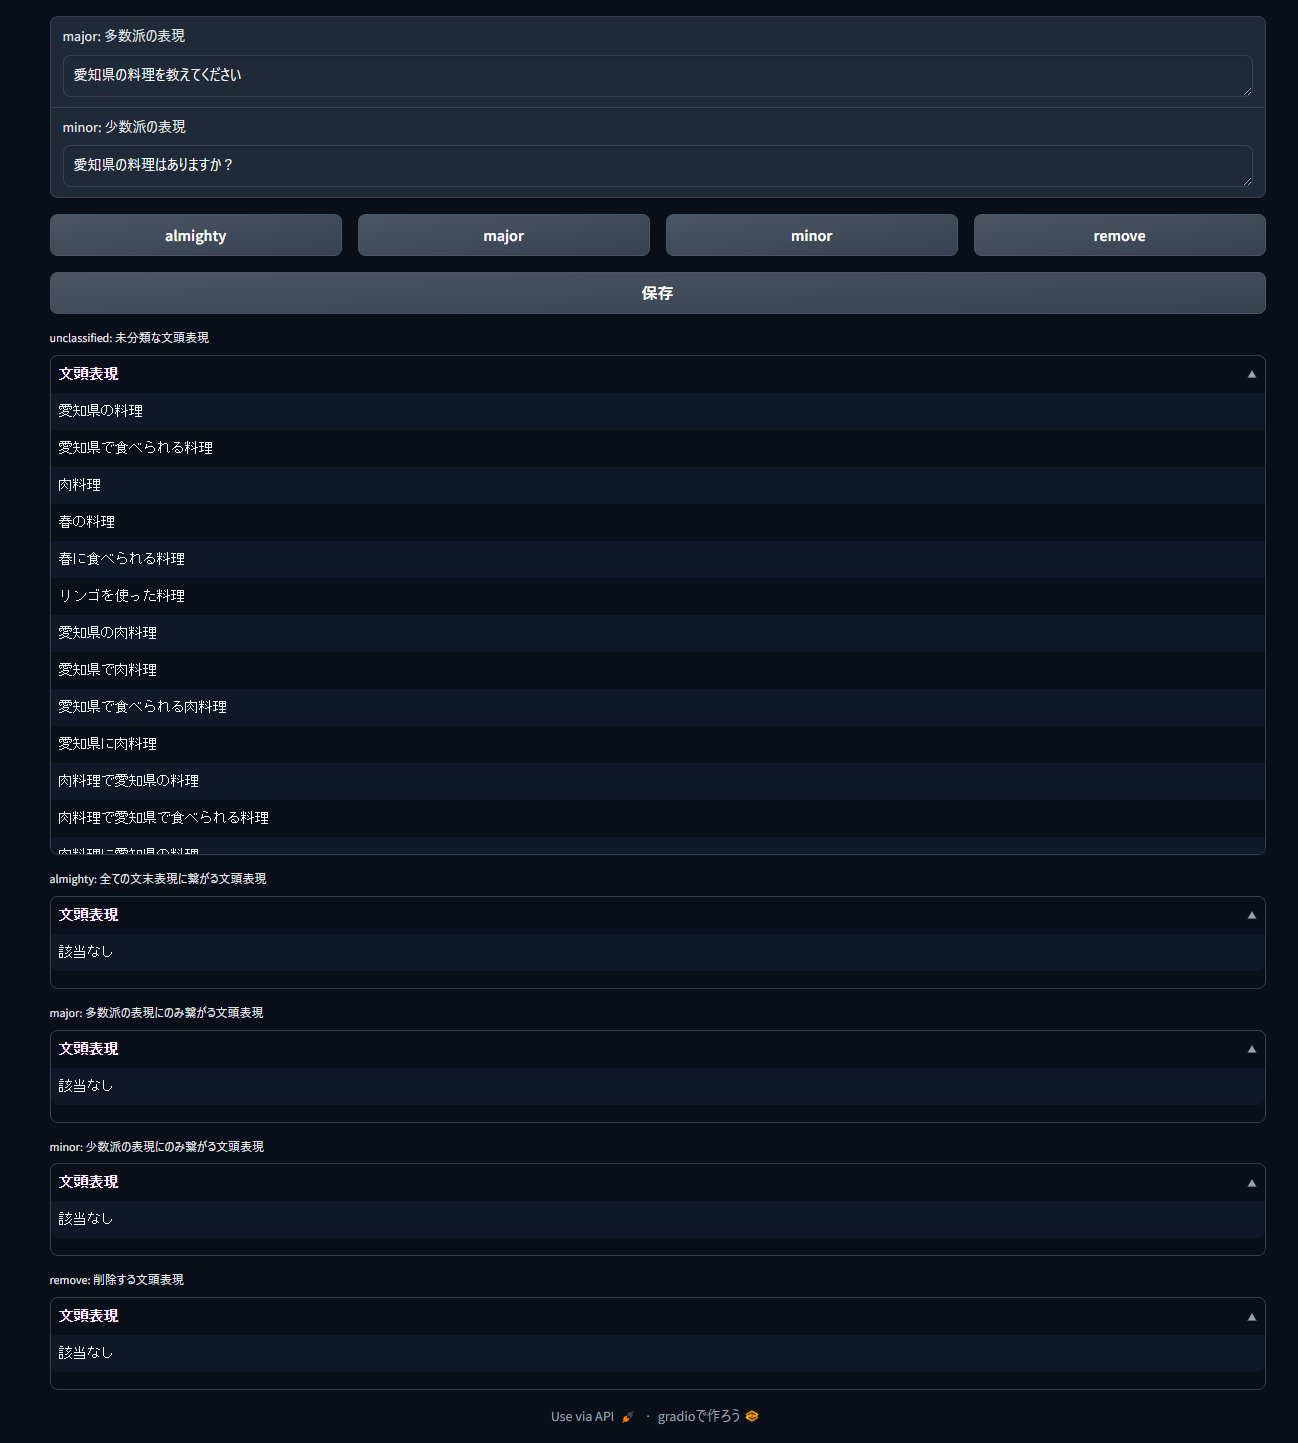

# メモ

※１
- クリックされたボタンの`value`を`inputs`で参照したいため、`gr.on`で、全ての`classify_btn`をまとめたイベントリスナーとしては作成しなかった

※２
- デフォルト値を`row_info.values`とすると、初期化時の`row_info.values`しか参照しないため、常に最新の`row_info.values`を参照するように、デフォルト値を`row_info`とした

※３
- 他のメソッドが、各情報を簡単に参照できるように作成した
- `row_info`をイベントリスナーの`inputs`に指定すれば、コンポーネントの`value`を参照できるが、その場合は文字列として参照するため、任意の情報をインデックスで指定して参照することができない